In [1]:
import sys; sys.path.append('/sj0243/')

In [2]:
from python_for_nustar.pyxspec_lib.nustar_xspec import scan_containers_ph_res, query_par, ph_res_param, Model, Fit, Plot, xspec, AllData, AllModels
from python_for_nustar.nu_core import set_mpl, plt
import astropy.io.fits as fits
from python_for_nustar.nu_class import NustarObservation, glob
from python_for_nustar.pipeline.sj0243_init import Nu_path, ObsList_bright, plot_path, ObsAlias
from cycler import cycler
import scipy

set_mpl('pastel')

xspec.AllModels.lmod('relxill', '/sj0243/python_for_nustar/relxill_model/')


In [3]:
set_mpl('pastel')
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'r', 'g', 'g', 'b','b', 'violet', 'violet', 'brown', 'brown', 'pink', 'pink'])))

In [9]:
def plot_pulse_profile(ObsID, ax_pp):

    ff_zero = fits.open(f'/sj0243/results/out{ObsID}/products/phase_resolved/phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')
    phase_zero = ff_zero[1].data["PHASE"]
    rate_zero = ff_zero[1].data["RATE1"]
    idx = np.where(~np.isnan(rate_zero))[0][0]
    ph_shift = phase_zero[idx] * (-1)



    f   = fits.open(f'/sj0243/results/out{ObsID}/products/spe_and_lc/spe_and_lcAB_sr.lc_bary_orb_corr_nphase_128.efold')
    ph, rate, err = f[1].data['PHASE']+ ph_shift,  f[1].data['RATE1'],  f[1].data['ERROR1']
    roll_idx  = 0#roll_idx = -np.argmin(rate)
    rate = np.roll(rate, roll_idx)
    err = np.roll(err, roll_idx)

    rate = np.tile(rate, 2)
    err = np.tile(err, 2)
    ph = np.hstack((ph, ph+1))

    ax_pp.step(ph, rate, where='mid', color = 'k', alpha = 0.7)
    return ph, rate


# Ratio to  cutoffpl

In [10]:

def plot_po_rat(
    ObsID,
    bin_numbers,
    min_sig = 120,
    gamma = '2',
    ecut = '40',
    ax = None,
):
    ms, alpha, lw = 4, 0.5, 0
    if ax is None:
        fig,  ax =  plt.subplots( figsize = (8, 3))
    else:
        fig = None
        pass
    #ax_pp = ax.inset_axes([0.3, 0.9, 0.4, 0.2])
    ax_pp = ax.inset_axes([0.3, 0.1, 0.4, 0.2])
    plot_pulse_profile(ObsID, ax_pp)
    ax_pp.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top = False,left=False)
    ax_pp.set_yticks([]) 
    

    for bin_number in bin_numbers:
        os.chdir(f"/sj0243/results/out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/relxill/xcm/{ObsID}_bin{bin_number}_shift0_relxill.xcm')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxill.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"
        print(f"Obs {ObsID}; bin {bin_number}; refl_factor = {refl_fract}")
        mo_loaded.relxill.refl_frac = '0 -1'

        mo_cutoffpl = Model("const*cutoffpl")
        mo_cutoffpl.cutoffpl.PhoIndex = str(gamma) + ' -1'
        mo_cutoffpl.cutoffpl.HighECut = str(ecut) + ' -1'

        mo_cutoffpl.setPars({1: '1. -1'})
        m2 = AllModels(2)
        m2.setPars({1: '1. '})
        Fit.query = 'yes'
        Fit.statMethod = "chi"
        Fit.query = "yes"
        Fit.perform()

        label = f'Bin {bin_number}; $f_{{refl}}$ = {refl_fract}'

        for gr, m, l in zip([1,2], ['o', 's'], [label, '_'+ label]):

            Plot.device = "/null"
            Plot.setRebin(min_sig, min_sig)
            Plot("rat")
            Plot.xAxis = "keV"
            en = np.array(Plot.x(gr))
            data = np.array(Plot.y(gr))
            en_err = np.array(Plot.xErr(gr))
            data_err = np.array(Plot.yErr(gr))


            ax.semilogx(en, data, marker = m, lw = lw, alpha = alpha, ms = ms)   
            color =  ax.get_lines()[-1].get_color()         
            ax.errorbar(en, data, data_err, en_err,
                            fmt='none', ecolor=color, alpha=alpha*0.7, label=l,)
            #data_interp = scipy.interpolate.CubicSpline(en, data)
            #en_axis = np.geomspace(en[0], en[-1], 250)
            #ax.plot(en_axis, data_interp(en_axis), '-', color = color, lw = 3, alpha = 0.6)
            if gr==1:
                b = bin_number
                ax_pp.axvspan((b-1)/10, b/10, color = color, alpha = 0.4)




        ax.set_xscale("log")
        #ax_rat.set_yscale("log")
        #ax.axvline(6.4, color="k", ls="--", lw=0.5)
        ax.set_xlabel("Energy (keV)")

        ax.set_ylabel(f"Ratio to cutoffpl,\n $\Gamma$={gamma}; $E_{{cut}}$={ecut} keV", fontsize = 14)
        l = ax.legend(loc="lower left", title = ObsAlias[ObsID], fontsize = 10,  title_fontsize = 10)
        l.set_zorder(-1)
        for lh in l.legendHandles:
            lh.set_alpha(1)
        # ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=8)
        ax.set_xticks([4, 6, 7, 10, 20, 40, 80])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())



    return fig, ax



 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 7; refl_factor = 0.11
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 4; refl_factor = 0.32


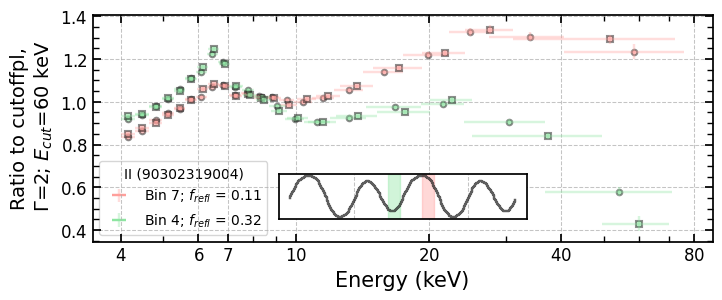

In [11]:
fig, ax = plot_po_rat('90302319004', [7,4], ecut = '60')


 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 2; refl_factor = 0.14
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 5; refl_factor = 0.44
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 7; refl_factor = 0.20


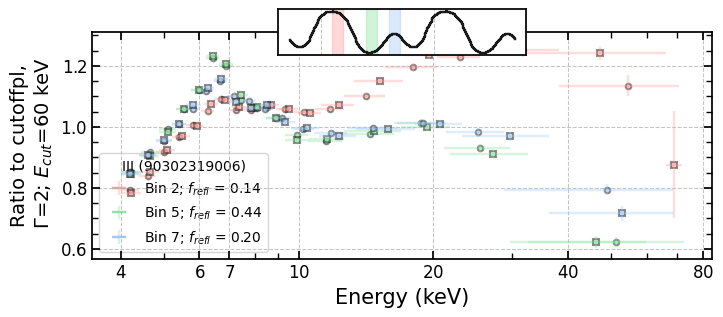

In [28]:
fig, ax = plot_po_rat('90302319006', [2,5,7], ecut = '60')

 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319008; bin 8; refl_factor = 0.06
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319008; bin 4; refl_factor = 0.07 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 



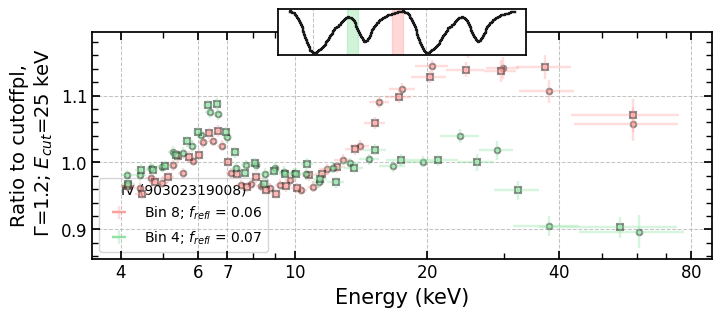

In [31]:
fig, ax = plot_po_rat('90302319008', [8,4], ecut = '25', gamma='1.2')

 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 7; refl_factor = 0.11
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 4; refl_factor = 0.32
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 2; refl_factor = 0.14
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 5; refl_factor = 0.44
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 7; refl_factor = 0.20
 *** 

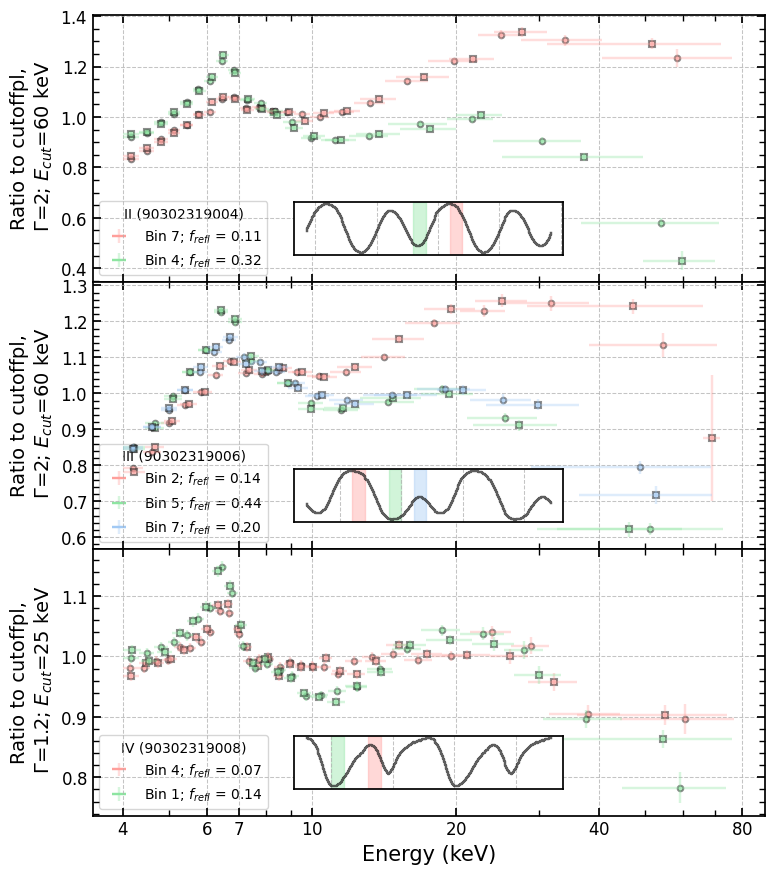

In [12]:
fig,  [ax1,ax2,ax3] =  plt.subplots(3, figsize = (8,9), sharex=True, gridspec_kw = {'hspace':0})
plot_po_rat('90302319004', [7,4], ecut = '60', ax = ax1)
plot_po_rat('90302319006', [2,5,7], ecut = '60', ax = ax2)
plot_po_rat('90302319008', [4,1], ecut = '25', gamma='1.2', ax = ax3)

fig.tight_layout()
fig.savefig(plot_path+ '/ph-res/cutoffpl_ratio.pdf')

# Spectra of reflection and model of  iron line

In [ ]:

def plot_relf_spe(
    ObsID,
    bin_numbers,
    min_sig = 120,
    en_po = 3,
    ax = None,
):
    ms, alpha, lw = 4, 0.5, 0

    ax_pp = ax.inset_axes([0.3, 0.9, 0.4, 0.2])
    plot_pulse_profile(ObsID, ax_pp)
    ax_pp.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top = False,left=False)
    ax_pp.set_yticks([]) 
    

    for bin_number in bin_numbers:
        os.chdir(f"/sj0243/results/out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        model = 'relxilllp'
        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"
        print(f"Obs {ObsID}; bin {bin_number}; refl_factor = {refl_fract}")
        mo_loaded.relxilllp.refl_frac = '0 -1'

        label = f'Bin {bin_number}; $f_{{refl}}$ = {refl_fract}'
        #label = f'Bin {bin_number};' +  r'f_{{refl}}' + str(refl_fract)

        #en_all = []
        #res_all = []
        #res_err_all = []
        for gr, m, l in zip([1,2], ['o', 's'], [label, '_'+ label]):

            Plot.device = "/null"
            Plot.setRebin(min_sig, min_sig)
            Plot("res")
            Plot.xAxis = "keV"
            en = np.array(Plot.x(gr))
            data = np.array(Plot.y(gr))
            en_err = np.array(Plot.xErr(gr))
            data_err = np.array(Plot.yErr(gr))

            data,data_err = data*en**en_po, data_err*en**en_po

            #en_all.append(en)
            #res_all.append(data)
            #res_err_all.append(data_err)
            # en = en_all[0]
            # data = (res_all[0]+res_all[1])/2
            # data_err = np.sqrt(res_err_all[0]**2+res_err_all[1]**2)
            ax.semilogx(en, data, marker = m, lw = lw, alpha = alpha, ms = ms)   
            color =  ax.get_lines()[-1].get_color()         
            ax.errorbar(en, data, data_err, en_err,
                            fmt='none', ecolor=color, alpha=alpha*0.7, label=l,)

            if gr==1:
                b = bin_number
                ax_pp.axvspan((b-1)/10, b/10, color = color, alpha = 0.4)




        ax.set_xscale("log")
        #ax_rat.set_yscale("log")
        ax.axvline(6.4, color="k", ls="--", lw=0.5)
        ax.set_xlabel("Energy (keV)")

        #ax_rat.set_title(title)
        ax.set_ylabel(f"$E^3 \\times$ (data - contunuum model)", fontsize = 14)
        l = ax.legend(loc="upper right", title = ObsAlias[ObsID], fontsize = 14,  title_fontsize = 14)
        l.set_zorder(-1)
        for lh in l.legendHandles:
            lh.set_alpha(1)
        # ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=8)
        ax.set_xticks([4, 6, 7, 10, 20, 40, 80])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())



    return ax





def plot_relf_spe_model(
    ObsID,
    bin_numbers,
    min_sig = 120,
    en_po = 3,
    ax = None,
):
    ms, alpha, lw = 4, 0.5, 0

    ax_pp = ax.inset_axes([0.3, 0.9, 0.4, 0.2])
    plot_pulse_profile(ObsID, ax_pp)
    ax_pp.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top = False,left=False)
    ax_pp.set_yticks([]) 
    

    for bin_number in bin_numbers:
        os.chdir(f"/sj0243/results/out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        model = 'relxilllp'
        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        AllData.dummyrsp(4, 79., 250)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"
        print(f"Obs {ObsID}; bin {bin_number}; refl_factor = {refl_fract}")
        mo_loaded.relxilllp.refl_frac = "-"+str(refl_fract)
        mo_loaded.bbodyrad.norm = '0 -1'
        mo_loaded.constant.factor = '1 -1'


        label = f'Bin {bin_number}; $f_{{refl}}$ = {refl_fract}'

        Plot.device = "/null"
        Plot.setRebin(min_sig, min_sig)
        Plot("eemo")
        Plot.xAxis = "keV"
        en = np.array(Plot.x())
        data = np.array(Plot.model())

        ax.loglog(en, data, marker = None, lw = 1.5, alpha = alpha, label = label)   
        color =  ax.get_lines()[-1].get_color()         
        ax.semilogx(en, data, marker = None, alpha = 0, label = '_'+label)   

        b = bin_number
        ax_pp.axvspan((b-1)/10, b/10, color = color, alpha = 0.4)




        ax.set_xscale("log")
        #ax_rat.set_yscale("log")
        ax.axvline(6.4, color="k", ls="--", lw=0.5)
        ax.set_xlabel("Energy (keV)")

        #ax_rat.set_title(title)
        ax.set_ylabel(f"reflection model", fontsize = 14)
        l = ax.legend(loc="upper right", title = ObsAlias[ObsID], fontsize = 14,  title_fontsize = 14)
        l.set_zorder(-1)
        for lh in l.legendHandles:
            lh.set_alpha(1)
        # ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=8)
        ax.set_xticks([4, 6, 7, 10, 20, 40, 80])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())



    return ax




Obs 90302319004; bin 4; refl_factor = 0.34
Obs 90302319004; bin 9; refl_factor = 0.35
Obs 90302319004; bin 1; refl_factor = 0.13
Obs 90302319004; bin 7; refl_factor = 0.12
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 4; refl_factor = 0.32
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 9; refl_factor = 0.33
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 1; refl_factor = 0.13
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319004; bin 7; refl_factor = 0.11
Obs 90302319004; bin 4; refl_fac

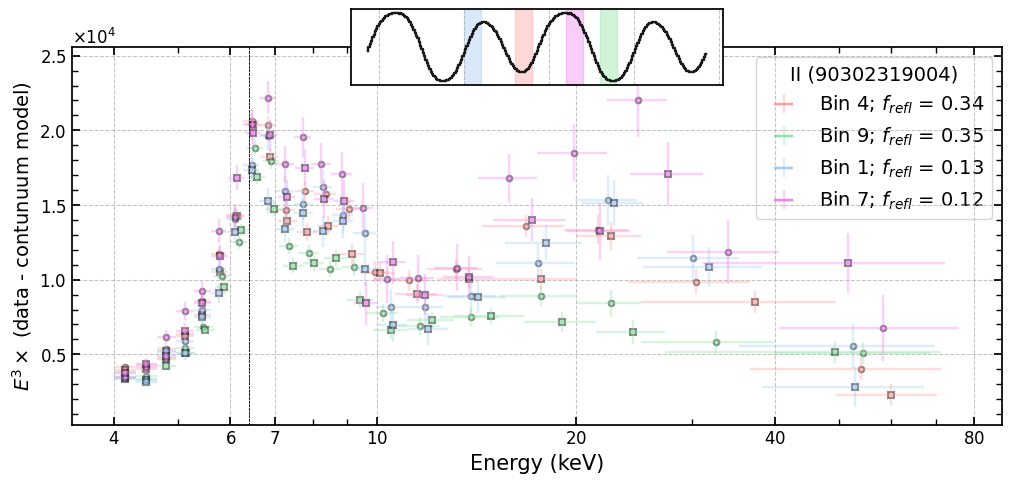

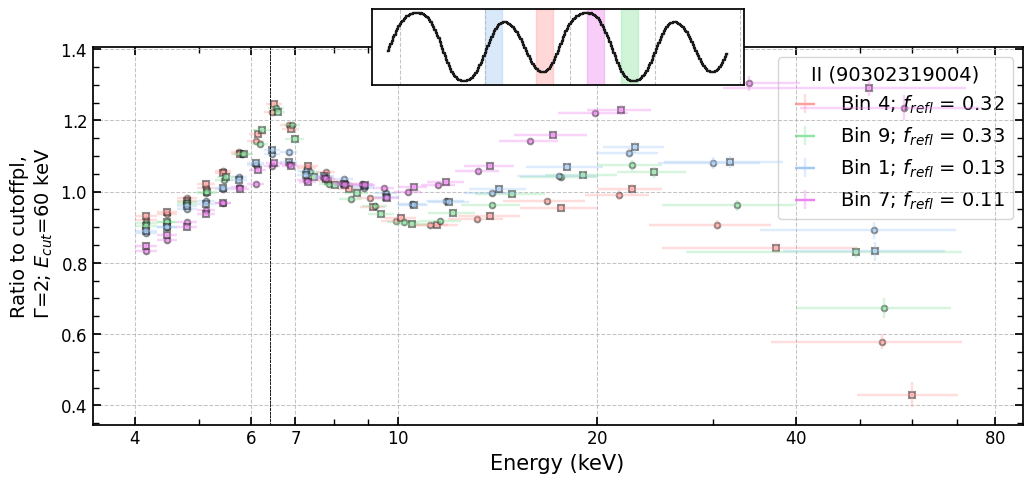

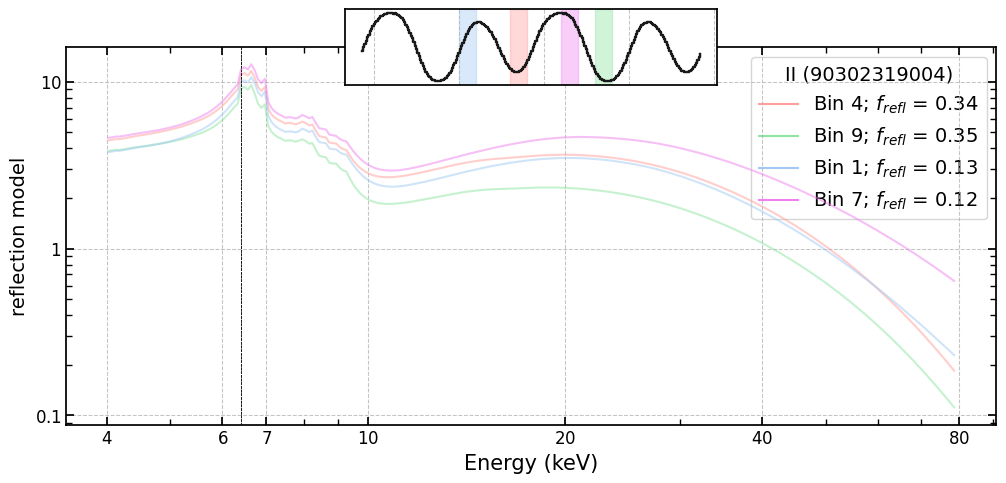

In [22]:
fig1,  ax1 =  plt.subplots( figsize = (12, 5))
fig2,  ax2 =  plt.subplots( figsize = (12, 5))
fig3,  ax3 =  plt.subplots( figsize = (12, 5))
plot_relf_spe('90302319004', [4, 9, 1, 7], ax=ax1)
plot_po_rat('90302319004', [4, 9, 1, 7], ax=ax2, ecut = '60')
plot_relf_spe_model('90302319004', [4, 9, 1, 7], ax=ax3)
#fig1.savefig(plot_path+ '/ph-res/refl_high1.pdf')
#fig2.savefig(plot_path+ '/ph-res/rat_high1.pdf')

Obs 90302319006; bin 5; refl_factor = 0.48
Obs 90302319006; bin 9; refl_factor = 0.43
Obs 90302319006; bin 2; refl_factor = 0.15
Obs 90302319006; bin 7; refl_factor = 0.21
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 5; refl_factor = 0.44
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 9; refl_factor = 0.40
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 2; refl_factor = 0.14
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319006; bin 7; refl_factor = 0.20
Obs 90302319006; bin 5; refl_fac

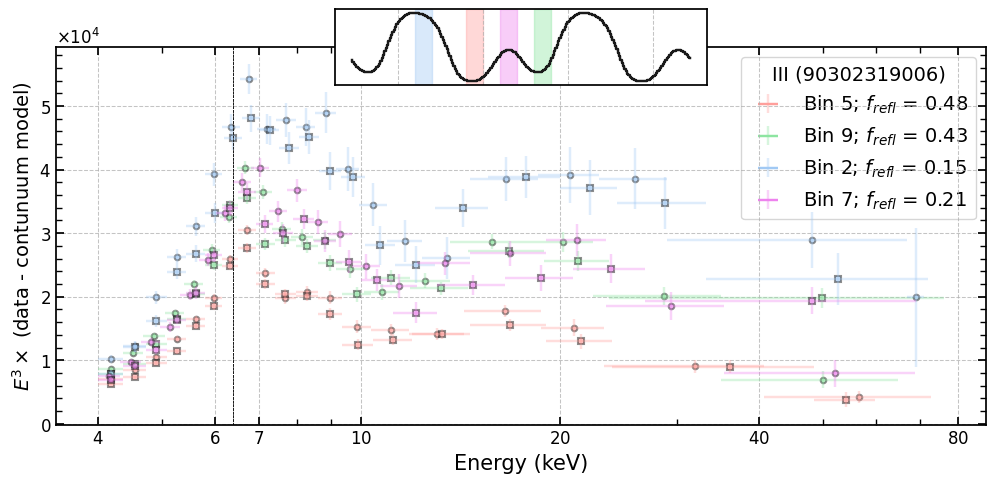

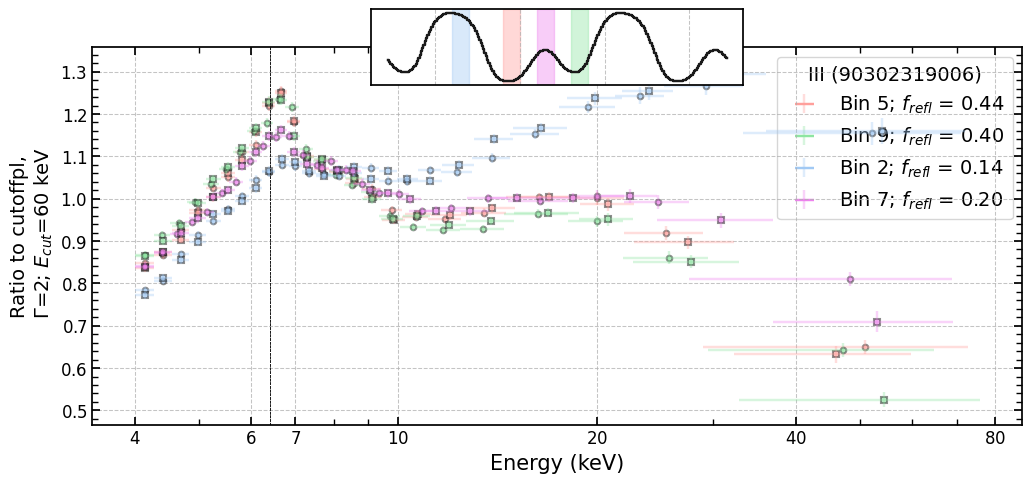

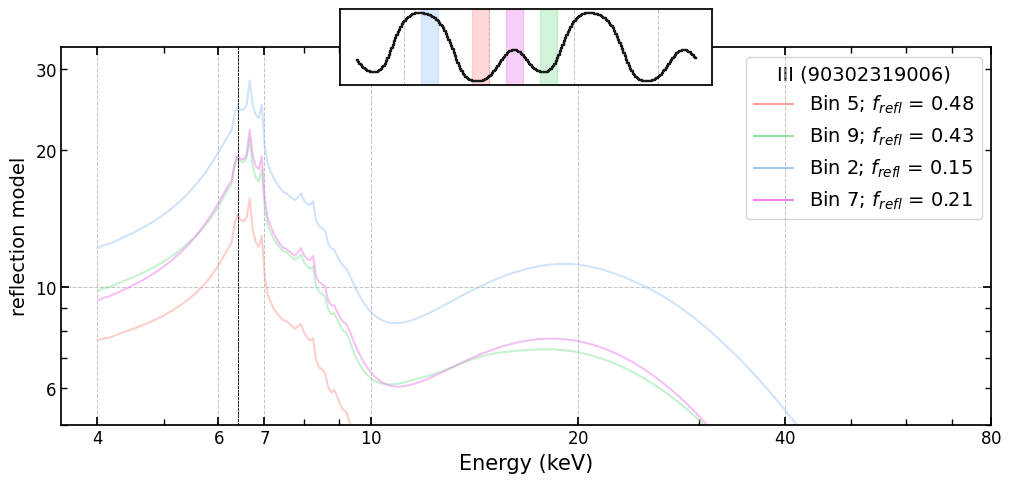

In [15]:
fig1,  ax1 =  plt.subplots( figsize = (12, 5))
fig2,  ax2 =  plt.subplots( figsize = (12, 5))
fig3,  ax3 =  plt.subplots( figsize = (12, 5))

plot_relf_spe('90302319006', [5, 9, 2, 7], ax=ax1, min_sig = 110,)
plot_po_rat('90302319006', [5, 9, 2, 7], ax=ax2, min_sig = 95, ecut = '60')
plot_relf_spe_model('90302319006', [5, 9, 2, 7], ax=ax3)

#fig1.savefig(plot_path+ '/ph-res/refl_high2.pdf')
#fig2.savefig(plot_path+ '/ph-res/rat_high2.pdf')

Obs 90302319006; bin 5; refl_factor = 0.48
Obs 90302319006; bin 9; refl_factor = 0.43
Obs 90302319006; bin 2; refl_factor = 0.15
Obs 90302319006; bin 7; refl_factor = 0.21


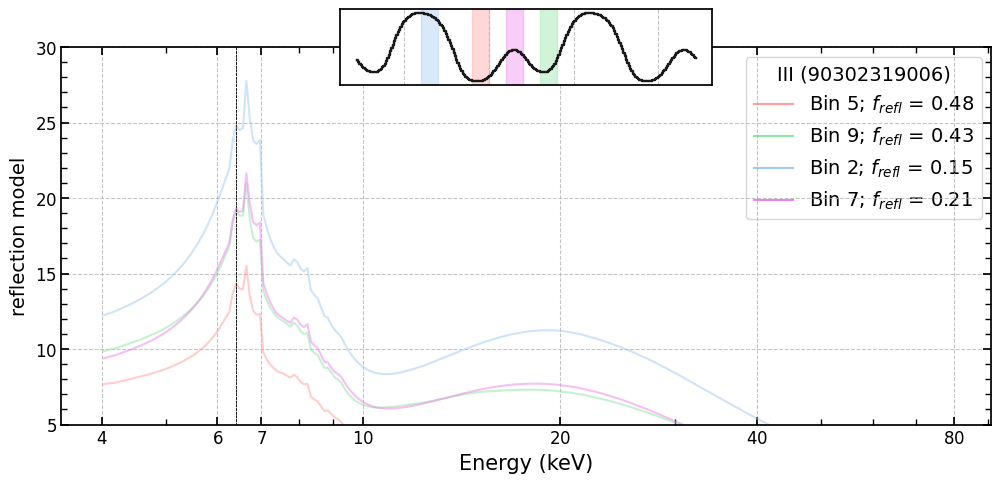

In [18]:
fig3,  ax3 =  plt.subplots( figsize = (12, 5))
plot_relf_spe_model('90302319006', [5, 9, 2, 7], ax=ax3)
ax3.set_ylim(5, 30)
ax3.set_yscale('linear')

Obs 90302319008; bin 1; refl_factor = 0.15
Obs 90302319008; bin 5; refl_factor = 0.10
Obs 90302319008; bin 4; refl_factor = 0.07
Obs 90302319008; bin 8; refl_factor = 0.07
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319008; bin 1; refl_factor = 0.14
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319008; bin 5; refl_factor = 0.09
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319008; bin 4; refl_factor = 0.07
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
 *** warning : Rbr < Rin, resetting Rbr=Rin; please set your limits properly 
Obs 90302319008; bin 8; refl_factor = 0.06
Obs 90302319008; bin 1; refl_fac

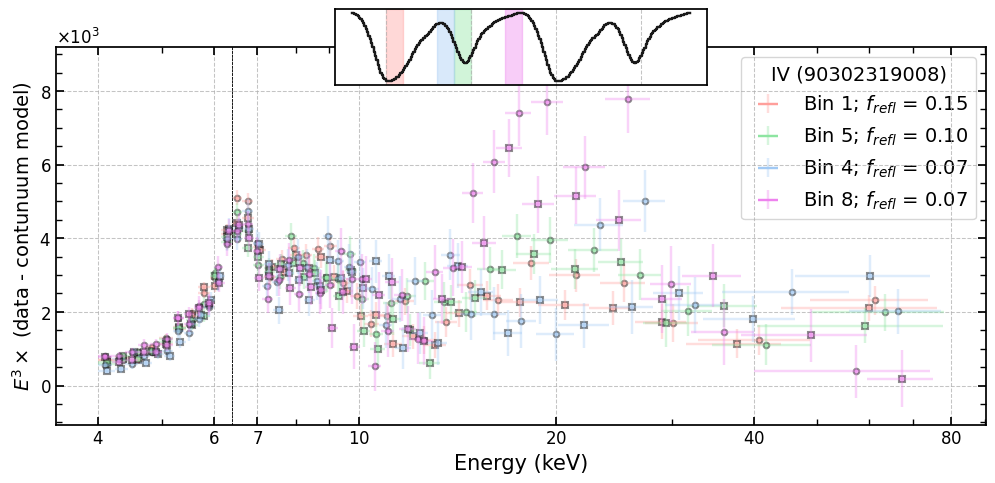

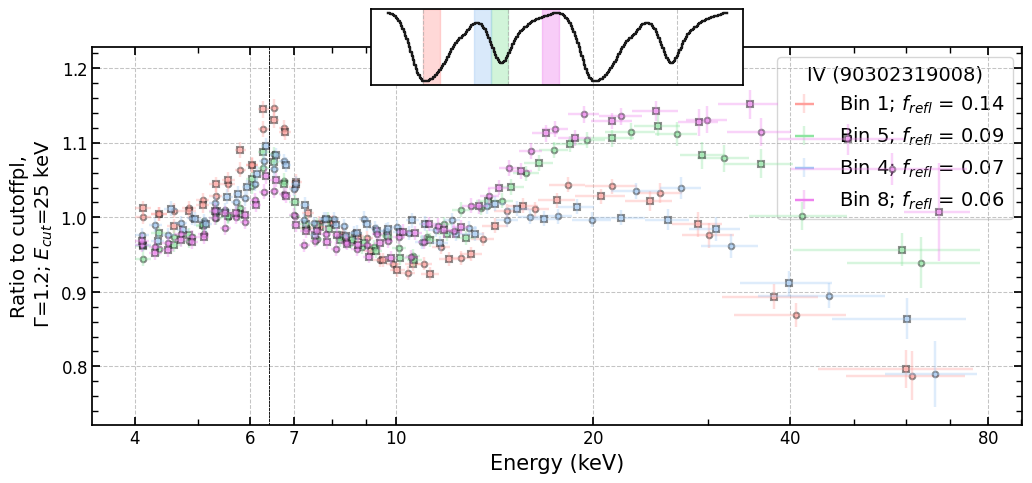

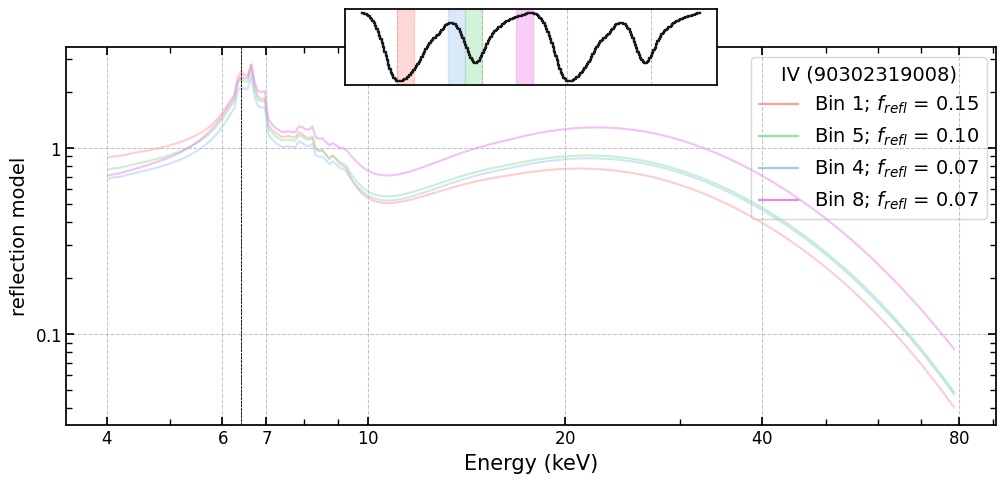

In [18]:
fig1,  ax1 =  plt.subplots( figsize = (12, 5))
fig2,  ax2 =  plt.subplots( figsize = (12, 5))
fig2,  ax3 =  plt.subplots( figsize = (12, 5))
plot_relf_spe('90302319008', [1, 5, 4, 8], ax=ax1, min_sig = 100)
plot_po_rat('90302319008',  [1, 5, 4, 8], ax=ax2, min_sig = 100, gamma='1.2', ecut = '25')
plot_relf_spe_model('90302319008', [1, 5, 4, 8], ax=ax3)
#fig1.savefig(plot_path+ '/ph-res/refl_high3.pdf')
#fig2.savefig(plot_path+ '/ph-res/rat_high3.pdf')